## Hi!

Welcome to Hands-On NLP! In this notebook I'll give you an interactive tour of a type of problem that I'm working on right now, named entity recognition.  I hope this will give you an idea of how to deal with various types of NLP problems, and you can take some of the things here and generalize them.

In this notebook, we'll be using a dataset from the The Groningen Meaning Bank (https://www.semanticscholar.org/paper/The-Groningen-Meaning-Bank-Bos/a86b5a3d2d23f00b7f3b5c45132ece7d125d4f8c) which contains about 50,000 English sentences annotated by the named entities they contain.

# 1. Let's load the data and give it a browse

In [293]:
import pandas as pd

data = pd.read_csv('data/ner_dataset.csv',encoding='latin1')
#The format of the csv is such that it only defines Sentence # for the first word in a sentence
#and then the words that follow in the sentence are null until the next sentence
#Use fillna to fill these in sequentially
data.fillna(method="ffill",inplace=True)
print(data['Sentence #'].unique().shape[0])
max_len = 75
max_len_char = 10

47959


In [294]:
data['Tag'].value_counts()/data['Tag'].value_counts().sum()

O        0.846776
B-geo    0.035900
B-tim    0.019391
B-org    0.019210
I-per    0.016452
B-per    0.016203
I-org    0.016006
B-gpe    0.015135
I-geo    0.007071
I-tim    0.006226
B-art    0.000383
B-eve    0.000294
I-art    0.000283
I-eve    0.000241
B-nat    0.000192
I-gpe    0.000189
I-nat    0.000049
Name: Tag, dtype: float64

Looks like we've got a very sparse dataset, with 'O' (outside of entity) being the vast majority of tags, which makes sense.  A lot of langauge is grammar, pronouns, broader ideas, etc. and not named entities.  

## What are the different entities?  Can we get some examples?

In [295]:
all_tags = data['Tag'].unique().tolist()
all_tags.remove('O')
all_tags.sort(key = lambda x: x.split('-')[1])
for tag in all_tags:
    print('________')
    print(tag)
    print('________')
    print(data[data['Tag']==tag]['Word'].head(20))

________
B-art
________
263       Nuclear
3769     Saltillo
3810    Pentastar
3814     Chrysler
3816        Dodge
3818         Jeep
3820          Ram
3863        Vioxx
3951        Vioxx
3962        Vioxx
3982        Vioxx
4015          The
4141         Good
4150        20/20
5234          Web
5243      english
5247        Daily
5253          Web
5698      alHurra
5922      Charles
Name: Word, dtype: object
________
I-art
________
264     Non-Proliferation
3811                  V-6
4016               Simple
4017                 Life
4142              Morning
4143              America
5248               Mirror
5923                   De
5924               Gaulle
5935        International
5936              Airport
6776                   of
6777               Tennis
6778        Professionals
6779                 Tour
7132                House
7133                 Rose
7134               Garden
8207               Street
8283                    3
Name: Word, dtype: object
________
B-eve
_____

Ok!  This is starting to make more sense now.

__per__ : Names of people.

__geo__ : Names of geographies, specifying a country, state, city, etc.

__gpe__ : Names of geopolitical entities, specifying that it's an entity that belongs to a geography, but not a geography itself.

__org__ : Names of organizations, groups like Labor Party, Internation Atomic Energy Agency, U.N. Security Council, or companies like Royal-Dutch Shell

__tim__ : Times like days of the week, dates, etc.

__nat__ : Natural phenomena like disease outbreaks, storms, etc.

__eve__ : These are events, like the Olympic Games or the Gulf War.

__art__ : Things which are named, but aren't a person, organization, geopolitical entity, time, event, natural event.  Some examples we found were: "Jeep", "Nuclear Non-Proliferation", "V-6."  These types of named entities look like they can be concepts, things like models of cars, or names of shows, etc.

Because some of the entities occur at very low frequencies, we're going to set an arbitrary cutoff, and just look at a few types of entities, namely: __geo__, __tim__, __gpe__, __per__, __org__.  This will still give us a lot of useful information and allow us to automatically find geographies, geopolitical entities, times, people, and organizations.  Our computer is going to learn how to read!  They grow up so fast 😭.

In [296]:
data['Tag'].value_counts()

#We'll define a list of tags to include in our model and set the rest to 'O' so they are ignored
include_tags = [
    'B-geo',
    'I-geo',
    'B-tim',
    'I-tim',
    'B-gpe',
    'I-gpe',
    'B-per',
    'I-per',
    'B-org',
    'I-org',    
]

#include_tags = data['Tag'].unique().tolist()
for tag in data['Tag'].unique():
    if tag not in include_tags:
        data.loc[data['Tag']==tag,'Tag'] = 'O'
        
n_tags = data['Tag'].unique().shape[0] #add 1 to account for PAD

In [297]:
data['Tag'].value_counts()/data['Tag'].value_counts().sum()

O        0.848218
B-geo    0.035900
B-tim    0.019391
B-org    0.019210
I-per    0.016452
B-per    0.016203
I-org    0.016006
B-gpe    0.015135
I-geo    0.007071
I-tim    0.006226
I-gpe    0.000189
Name: Tag, dtype: float64

Cool, now we've only got our defined subset of tags, and they're generally >1% of the words in the dataset (with a few exceptions)

# 2. Preparing text for model inputs

Later, we're going to create a neural networks that can read sentences and find the entities contained.  To accomplish this, the network has to be able to read a sentence word-by-word and find relationships in sequences of words to determine their relationships as entity chunks.  

The first thing we'll do, is define a lookup table for all of the words contained in our corpus.  This just takes every single word and gives it an integer value so we can use it in a sparse input matrix.  

We'll reserve 0 for "padding" values (padding is adding null values to the end of a sentence so that all sentences are the same length) and 1 for "UNK" (unknown words that the model has never encountered before).  With these mappings, we can handle any input that is thrown at our model.

In [298]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

Now, we'll aggregate our individual word entries into sequences of words, more commonly known as sentences.  We'll also aggregate our `Tags` into corresponding sequences so that we have all of our named entity tags to match up with the words in the sentences.

In [299]:
agg_func_words = lambda s: [w for w in s["Word"].values.tolist()]
X = data.groupby("Sentence #").apply(agg_func_words)

agg_func_labels = lambda s: [w for w in s["Tag"].values.tolist()]
y = data.groupby("Sentence #").apply(agg_func_labels)


Ok, now that we've got all of words in our sentences separated out into sequences, let's decide on what we should set our max_len value to.

First, we'll take a look at a histogram to give us an idea of how the sentence lengths are distributed.

Text(0.5,1,'Mean=21.86, Median=21.0, StDev=7.96, Max=104, Min=1')

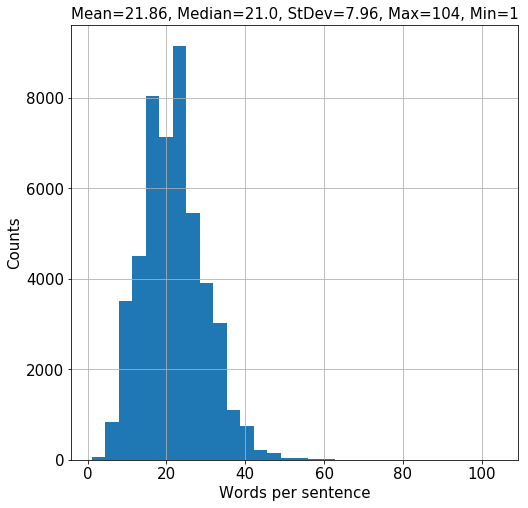

In [300]:
plt.figure(figsize=(8,8))
sent_lengths = X.apply(len)
sent_lengths.hist(bins=30)
avg_sent_length = sent_lengths.mean().round(2)
med_sent_length = sent_lengths.median().round(2)
std_sent_length = sent_lengths.std().round(2)
min_sent_length = sent_lengths.min()
max_sent_length = sent_lengths.max()
plt.ylabel('Counts',fontsize=15)
plt.xlabel('Words per sentence',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(
    'Mean={}, Median={}, StDev={}, Max={}, Min={}'.format(
        avg_sent_length,
        med_sent_length,
        std_sent_length,
        max_sent_length,
        min_sent_length
    ),
    fontsize=15
)

Our sentences are on average ~20 words.  However, they can be as long as 104 words but it looks like that's really rare.  Above ~60 words/sentence, the proportion becomes really low.  Let's see what exactly the counts look like above 60 words/sentence. 

In [301]:
X[X.apply(len)>60].apply(len).value_counts().sort_index()

61     3
62     3
63     2
65     1
66     3
67     1
70     3
72     1
73     1
81     1
104    1
dtype: int64

So sentences above 70 words/sentences are extremely rare outliers.  Just to give us a little wiggle room, let's set our `max_len` to 75.

In [302]:
max_len = 75

Now, our model is going to have a defined structure with a definite input and output shape.  Sentences can be different lengths and, in fact, our dataset has sentences of various lengths.  Since our network expects a fixed length, we'll define what that fixed sentence length is (max_len), and do one of two things to each sentence:

* Pad sentences that are shorter than `max_len` with the null `PAD` value out to `max_len`

* Truncate sentences that are longer than `max_len` to `max_len`

In [303]:
from keras.preprocessing.sequence import pad_sequences

import numpy as np
X_word = [[word2idx[w] for w in s] for s in X.tolist()]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

We'll do the same thing for our `TAG` values which are the labels for the named entities

In [304]:
y = [[tag2idx[w] for w in s] for s in y]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


Word embeddings are great, and we've accounted for unknown words with the "UNK" value in the lookup dictionary.  But these are rather inflexible as misspellings, slightly different spellings, and other variations on words will all be funneled into the "UNK" value.  We'd also like our model to be able to account for words that are closely related to things we've seen in the past.  To do this, we can build an additional input called a __character embedding__.  

Character embeddings take all of the unique characters in our dataset and map them to a lookup table.  Then, we use a neural network at the character input to read all of the characters in a word and produce a vector that gives a layer of meaning on the characters contained within each word itself.  

At the end, we conatenate the __word__ and __character__ embeddings together for a unified word-character embedding that has a vector with information about all of the words we know exist, and relationships about sequences of characters that we've seen before.  The result of this is a much more flexible input embedding that doesn't simply ignore unknown words, but uses the information from their character embeddings to place them in our vector space in proximity to knowns words that we've seen before.  In classical NLP we may use something like __Levenshtein Distance__ (https://en.wikipedia.org/wiki/Levenshtein_distance) to accomplish this, but here we're going to build this understanding into the input layers of our neural network so it can learn it by itself.

Ok, that was a lot.  But, before we come up with a character lookup dictionary we need to define a static character length input, similar to how we defined `max_len` for words, as our neural network's character input will also have a fixed dimensionality

Text(0.5,1,'Mean=4.77, Median=4.0, StDev=2.82, Max=64, Min=1')

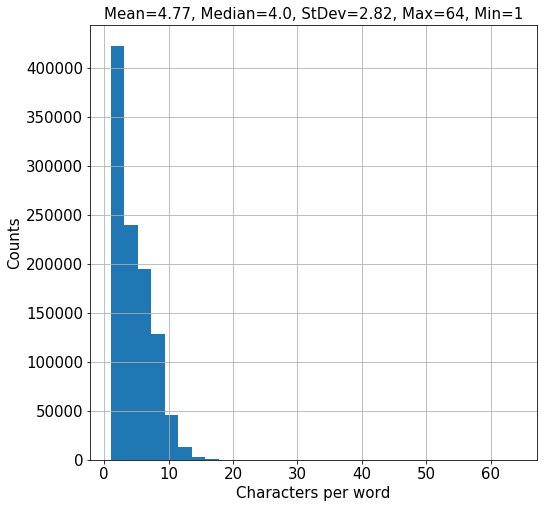

In [305]:
plt.figure(figsize=(8,8))
word_char_lens = data['Word'].apply(len)
word_char_lens.hist(bins=30)
avg_word_length = word_char_lens.mean().round(2)
med_word_length = word_char_lens.median().round(2)
std_word_length = word_char_lens.std().round(2)
min_word_length = word_char_lens.min()
max_word_length = word_char_lens.max()
plt.ylabel('Counts',fontsize=15)
plt.xlabel('Characters per word',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(
    'Mean={}, Median={}, StDev={}, Max={}, Min={}'.format(
        avg_word_length,
        med_word_length,
        std_word_length,
        max_word_length,
        min_word_length
    ),
    fontsize=15
)

Ok, so most of our words are on average 4-5 characters long.  But there's a word that's __64__ characters long!  What?  Let's see what the extraordinarily long words in our corpus are. 

In [306]:
data[data['Word'].apply(len)>25]['Word']

2895                              internationally-recognized
158260                           cricketer-turned-politician
196093     https://www.celebritiesforcharity.org/raffles/...
438072                            presidential-parliamentary
897232                            internationally-recognized
1006194                           internationally-recognized
Name: Word, dtype: object

Whew, now we can see that the 64 character long word is a website.  Other long words are contractions.  That makes sense.  We could deal with this more systematically, but since these instances are rare and beyond the scope of this exercise we'll just leave them be for now.

Ok, now that we've got an idea of the length of the words in our corpus, let's define a maximum character length. We'll go about this the same way we went about defining the max sentence length.  Let's see how many words with > 10 characters we have.

In [307]:
data[data['Word'].apply(len)>=10]['Word'].apply(len).value_counts().sort_index()

10    29468
11    16020
12     8087
13     4978
14     2444
15      809
16      416
17      413
18      202
19       82
20       43
21       39
22       12
23        4
24        5
26        4
27        1
64        1
Name: Word, dtype: int64

Looks like words that are longer than 15 characters become exceedingly rare.  Let's set our max_char_len to 15.

In [308]:
max_len_char = 15

Finally, we can define our character lookup table.

In [309]:
#First get all of the unique characters in all of our words
words = data['Word'].unique().tolist()
chars = set([c for w in words for c in w])
#define n_chars for our neural network's inputs later
n_chars = len(chars)
#now make a character lookup dictionary
char2idx = {c: i + 2 for i, c in enumerate(chars)}
#give ourselves flexibility to accept unknown chars and define a padding character
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in X.tolist():
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

Ok, we've got the data into a format that can be fed into our model.  Now let's split off 10% of the data into a `test` set, which we'll withold from our model during training.  We'll use this `test` set later to see how well our model generalizes to data that it's never seen before.

In [310]:
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=17)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=17)

# Build a Model

Let's start building a model.  

In [311]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

def create_model_cnn():
    word_in = Input(shape=(max_len,))
    emb_word = Embedding(input_dim=len(word2idx)+1, output_dim=20,
                         input_length=max_len, mask_zero=False)(word_in)

    # input and embeddings for characters
    char_in = Input(shape=(max_len, max_len_char,))
    emb_char = TimeDistributed(
        Embedding(
            input_dim=len(char2idx), 
            output_dim=10,
            input_length=max_len_char, 
            mask_zero=False
        )
    )(char_in)
    # character LSTM to get word encodings by characters
    char_enc = TimeDistributed(
        LSTM(
            units=20, 
            return_sequences=False,
            recurrent_dropout=0.5
        )
    )(emb_char)
    x = concatenate([emb_word, char_enc])
    
    drop_out = Dropout(0.5)(x)
    cnn_layer = Conv1D(
        kernel_size=3,
        filters=30,
        padding='same',
        activation='tanh',
        strides=1
    )(drop_out)
    spat_dropout = SpatialDropout1D(0.3)(cnn_layer)
    main_lstm = Bidirectional(
        LSTM(
            units=50, 
            return_sequences=True,
            recurrent_dropout=0.6
        )
    )(spat_dropout)
    
    out = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(main_lstm)
    model = Model([word_in, char_in], out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    model.summary()
    return model
model = create_model_cnn()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, 75, 15)       0                                            
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_86 (TimeDistri (None, 75, 15, 10)   1000        input_62[0][0]                   
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 75, 20)       703600      input_61[0][0]                   
__________________________________________________________________________________________________
time_distr

In [312]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5
    ),
    ModelCheckpoint(
        filepath='models/ner_checkpoint_test.h5', 
        monitor='val_loss', 
        save_best_only=True
    )
]



history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len,1),
                    batch_size=32, 
                    epochs=100, 
                    validation_split=0.1, 
                    callbacks = callbacks, 
                    verbose=1
)

Train on 38846 samples, validate on 4317 samples
Epoch 1/100
38846/38846 [==============================] - 176s 5ms/step - loss: 0.1982 - val_loss: 0.0622
Epoch 2/100
38846/38846 [==============================] - 176s 5ms/step - loss: 0.0576 - val_loss: 0.0379
Epoch 3/100
38846/38846 [==============================] - 182s 5ms/step - loss: 0.0411 - val_loss: 0.0331
Epoch 4/100
38846/38846 [==============================] - 166s 4ms/step - loss: 0.0348 - val_loss: 0.0310
Epoch 5/100
38846/38846 [==============================] - 175s 4ms/step - loss: 0.0314 - val_loss: 0.0301
Epoch 6/100
38846/38846 [==============================] - 193s 5ms/step - loss: 0.0294 - val_loss: 0.0291
Epoch 7/100
38846/38846 [==============================] - 194s 5ms/step - loss: 0.0279 - val_loss: 0.0288
Epoch 8/100
38846/38846 [==============================] - 198s 5ms/step - loss: 0.0266 - val_loss: 0.0286
Epoch 9/100
38846/38846 [==============================] - 213s 5ms/step - loss: 0.0257 - val_l

# 3. Validation

At long last, we can use the model to predict the labels for our test set.  

In [313]:
y_pred = np.argmax(
    model.predict(
        [X_word_te,np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))]
    ),
    axis=-1
)

And we'll use a confusion matrix to see how we did on each `Tag`

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          save_file = 'confusion_matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    --inputs--
    cm - the confusion matrix produced by sklearns confusion_matrix function
    classes - the labels for the classes in the confusion matrix

    --outputs--
    matplotlib figure displaying the confusion matrix, and the saved png of the figure

    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
 


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.savefig('figures/{}.png'.format(save_file))
    plt.show()

Normalized confusion matrix


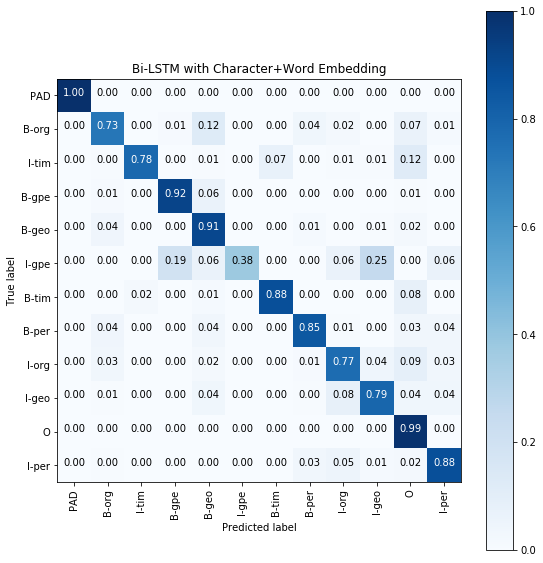

In [315]:
from sklearn.metrics import confusion_matrix

def switch_keys_values_dict(d):
    switch_dict = dict()
    for t in tag2idx.keys():
        switch_dict[d[t]] = t
    return switch_dict
        
idx2tag = switch_keys_values_dict(tag2idx)

labels = list()
for i in range(0,len(idx2tag)):
    labels.append(idx2tag[i])
y_pred = np.argmax(model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))]),axis=-1)
pred_labels = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])

test_labels = y_te.reshape(y_te.shape[0]*y_te.shape[1])


cnf_matrix = confusion_matrix(test_labels,pred_labels)
cnf_title = 'Bi-LSTM with Character+Word Embedding'
save_all = 'confusion_matrix_all'
plot_confusion_matrix(
    cnf_matrix, 
    classes=labels, 
    normalize=True,
    title=cnf_title,
    save_file=save_all
)

Let's summarize some of the confusion matrix output in a classification report, which will give us precision, recall, and f1 per class.

In [316]:
from sklearn.metrics import classification_report
#Let's use pandas to map our numerical labels to text labels
label_df = pd.DataFrame(columns = ['true','predicted'])
label_df['true'] = test_labels
label_df['predicted'] = pred_labels

label_df['true']  = label_df['true'].map(idx2tag)
label_df['predicted'] = label_df['predicted'].map(idx2tag)
print(classification_report(label_df['true'].values,label_df['predicted'].values))


              precision    recall  f1-score   support

       B-geo       0.85      0.91      0.88      3779
       B-gpe       0.96      0.92      0.94      1526
       B-org       0.77      0.73      0.75      2046
       B-per       0.82      0.85      0.84      1680
       B-tim       0.91      0.88      0.89      2053
       I-geo       0.80      0.79      0.80       764
       I-gpe       1.00      0.38      0.55        16
       I-org       0.81      0.77      0.79      1737
       I-per       0.86      0.88      0.87      1693
       I-tim       0.82      0.78      0.80       685
           O       0.99      0.99      0.99     88591
         PAD       1.00      1.00      1.00    255130

   micro avg       0.99      0.99      0.99    359700
   macro avg       0.88      0.82      0.84    359700
weighted avg       0.99      0.99      0.99    359700



# 4. Conclusion